## Modelo de Machine Learning - Prevenção de Fraudes

##### Começaremos com a análise exploratória e limpeza dos dados
* Tratamento de valores nulos
* Engenharia de atributos
* Verificação de outliers
* Gráfico para análise visual dos dados

##### Depois vamos tratar nossas variáveis para aplicação do modelo de machine learning
* Normalização, padronização das variáveis preditoras
* Balanceamento das variável target
* Criação, treino e teste de modelos preditivos com 3 algoritmos diferentes (Random Forest, Suport Vector e KNN)

### Imports

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

### Importação dos Dados e Análise Exploratória

In [2]:
# Importação dos dados
df = pd.read_csv('dados_coletados10k.csv')

In [3]:
# Visão geral dos dados
df.head()

,Contrato,Idade,Sexo,Valor_Renda,UF_Cliente,Perc_Juros,Prazo_Emprestimo,Data_Contratacao,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Escolaridade,Possui_Patrimonio,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude
0,322068935715,43,M,5800.00,SP,23.00,200,2022-08-01,193,80000.00,92000.00,15,9,1,0,DIVORCIADO,Nenhum,N,0.00,0,NaN,91759.97,7717.08,Nao
1,322068936715,22,M,2000.00,MG,20.00,100,2022-08-01,89,50000.00,57500.00,10,10,0,0,SOLTEIRO(A),NaN,N,0.00,4,103.00,53981.18,6756.59,Nao
2,322068938715,35,M,4000.00,BA,18.00,100,2022-08-01,85,100000.00,115000.00,15,5,1,0,CASADO (A),NaN,N,0.00,0,NaN,101150.02,17929.06,Nao
3,322068939715,20,M,1800.00,MG,20.00,100,2022-08-01,89,30000.00,34500.00,1,1,0,0,SOLTEIRO(A),NaN,N,0.00,13,376.00,36208.10,369.10,Sim
4,322068940715,53,M,2800.00,MG,20.00,100,2022-08-01,87,60000.00,69000.00,16,16,0,0,CASADO (A),NaN,N,0.00,0,NaN,60984.00,11845.24,Nao


In [4]:
# Tamanho da base de dados
df.shape

(9517, 24)

In [5]:
# Período dos dados
dt_inicio = pd.to_datetime(df['Data_Contratacao']).dt.date.min()
dt_fim = pd.to_datetime(df['Data_Contratacao']).dt.date.max()
print('O período analisado é de', dt_inicio, 'a', dt_fim)

O período analisado é de 2022-07-04 a 2022-12-20


In [6]:
# Tipo dos dados
df.info(verbose=True) # verbose=True para impedir barra de rolagem

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Contrato                          9517 non-null   int64  
 1   Idade                             9517 non-null   int64  
 2   Sexo                              9517 non-null   object 
 3   Valor_Renda                       9517 non-null   float64
 4   UF_Cliente                        9517 non-null   object 
 5   Perc_Juros                        9517 non-null   float64
 6   Prazo_Emprestimo                  9517 non-null   int64  
 7   Data_Contratacao                  9517 non-null   object 
 8   Prazo_Restante                    9517 non-null   int64  
 9   VL_Emprestimo                     9517 non-null   float64
 10  VL_Emprestimo_ComJuros            9517 non-null   float64
 11  QT_Total_Parcelas_Pagas           9517 non-null   int64  
 12  QT_Tot

In [7]:
# Visualizando medidas estatísticas
df.describe()

,Contrato,Idade,Valor_Renda,Perc_Juros,Prazo_Emprestimo,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago
count,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,5923.00,9517.00,9517.00
mean,322078158460.93,38.74,8325.40,19.65,107.43,104.58,81881.89,94164.17,7.89,4.11,1.60,1.24,10.93,5.35,249.79,90560.27,8166.21
std,5434160.86,12.67,121862.06,3.82,62.49,68.57,94138.06,108258.77,5.17,4.04,2.31,1.17,1025.26,5.32,123.22,111050.54,16697.76
min,322068935715.00,6.00,450.00,7.00,15.00,0.00,3500.00,4025.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00
25%,322073331715.00,29.00,2300.00,18.00,60.00,51.00,20000.00,23000.00,2.00,1.00,0.00,0.00,0.00,0.00,162.00,18546.85,1202.04
50%,322078461715.00,37.00,3400.00,20.00,80.00,80.00,50000.00,57500.00,9.00,2.00,1.00,1.00,0.00,4.00,284.00,45375.30,3949.91
75%,322082622715.00,46.00,5000.00,22.00,190.00,185.00,100000.00,115000.00,13.00,6.00,2.00,2.00,0.00,11.00,344.00,119721.25,8302.01
max,322087622715.00,91.00,8000080.00,28.00,240.00,227.00,500000.00,575000.00,35.00,35.00,14.00,9.00,100000.00,15.00,435.00,625000.00,396385.00


In [8]:
# Verificando valores nulos
df.isnull().sum()

Contrato                               0
Idade                                  0
Sexo                                   0
Valor_Renda                            0
UF_Cliente                             0
Perc_Juros                             0
Prazo_Emprestimo                       0
Data_Contratacao                       0
Prazo_Restante                         0
VL_Emprestimo                          0
VL_Emprestimo_ComJuros                 0
QT_Total_Parcelas_Pagas                0
QT_Total_Parcelas_Pagas_EmDia          0
QT_Total_Parcelas_Pagas_EmAtraso       0
Qt_Renegociacao                        0
Estado_Civil                           0
Escolaridade                        7105
Possui_Patrimonio                      0
VL_Patrimonio                          0
QT_Parcelas_Atraso                     0
QT_Dias_Atraso                      3594
Saldo_Devedor                          0
Total_Pago                             0
Possivel_Fraude                        0
dtype: int64

In [9]:
# Valores únicos de cada variável
valores_unicos = []

for i in df.columns[0:24].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    valores_unicos.append(len(df[i].astype(str).value_counts()))

Contrato : 9517
Idade : 74
Sexo : 2
Valor_Renda : 855
UF_Cliente : 27
Perc_Juros : 21
Prazo_Emprestimo : 36
Data_Contratacao : 110
Prazo_Restante : 79
VL_Emprestimo : 61
VL_Emprestimo_ComJuros : 61
QT_Total_Parcelas_Pagas : 24
QT_Total_Parcelas_Pagas_EmDia : 24
QT_Total_Parcelas_Pagas_EmAtraso : 15
Qt_Renegociacao : 10
Estado_Civil : 6
Escolaridade : 6
Possui_Patrimonio : 2
VL_Patrimonio : 3
QT_Parcelas_Atraso : 16
QT_Dias_Atraso : 16
Saldo_Devedor : 7654
Total_Pago : 7022
Possivel_Fraude : 2


In [10]:
# Avaliando maior e menor valor de Valor_Renda
print('Maior Renda:', df['Valor_Renda'].max())
print('Menor Renda:', df['Valor_Renda'].min())

Maior Renda: 8000080.0
Menor Renda: 450.0


In [11]:
# Avaliando maior e menor valor de QT_Dias_Atraso
print('Maior qtd de dias em atraso:', df['QT_Dias_Atraso'].max())
print('Menor qtd de dias em atraso:', df['QT_Dias_Atraso'].min())

Maior qtd de dias em atraso: 435.0
Menor qtd de dias em atraso: 11.0


In [12]:
# Avaliando maior e menor valor de Prazo_Restante
print('Maior qtd de dias restantes:', df['Prazo_Restante'].max())
print('Menor qtd de dias restantes:', df['Prazo_Restante'].min())

Maior qtd de dias restantes: 227
Menor qtd de dias restantes: 0


##### Agrupando dados das variáveis categóricas

In [13]:
# Sexo
df.groupby(['Sexo']).size().sort_values(ascending=False)

Sexo
M    5706
F    3811
dtype: int64

In [14]:
# Estado Civil
df.groupby(['Estado_Civil']).size().sort_values(ascending=False)

Estado_Civil
SOLTEIRO(A)      5087
CASADO (A)       3027
OUTRO             652
DIVORCIADO        481
VIÚVO(A)          140
UNIÃO ESTAVEL     130
dtype: int64

In [15]:
# Escolaridade
df.groupby(['Escolaridade']).size().sort_values(ascending=False)

Escolaridade
Nenhum                                  2184
Ensino Médio                             129
Ensino Superior                           74
Ensino Fundamental                        18
Pós Graduação / Mestrado / Doutorado       7
dtype: int64

In [16]:
# Estado
df.groupby(['UF_Cliente']).size().sort_values(ascending=False)

UF_Cliente
SP    2468
MG    1637
BA     883
PR     693
GO     485
PA     420
RS     407
MA     403
RJ     335
SC     298
PE     263
CE     248
MS     238
PB     154
MT     137
PI     104
AL      79
RN      78
ES      49
DF      46
SE      45
TO      19
RO      16
AP       5
RR       4
AM       2
AC       1
dtype: int64

In [17]:
# Patrimônio
df.groupby(['Possui_Patrimonio']).size().sort_values(ascending=False)

Possui_Patrimonio
N    9452
S      65
dtype: int64

In [18]:
# Fraude
df.groupby(['Possivel_Fraude']).size().sort_values(ascending=False)

Possivel_Fraude
Nao    5035
Sim    4482
dtype: int64

### Engenharia de Atributos

In [19]:
# Ajustando Estado_Civil
df['Estado_Civil'] = df['Estado_Civil'].replace(['NENHUM'], 'OUTRO')
df['Estado_Civil'] = df['Estado_Civil'].replace(['UNIÃO ESTAVEL'], 'CASADO (A)')

df.groupby(['Estado_Civil']).size().sort_values(ascending=False)

Estado_Civil
SOLTEIRO(A)    5087
CASADO (A)     3157
OUTRO           652
DIVORCIADO      481
VIÚVO(A)        140
dtype: int64

In [20]:
# Criando faixa etária
bins = [0, 21, 30, 40, 50, 60, 100]
labels = ['Até 21 anos', 'De 22 até 30 anos', 'De 31 até 40 anos', 'De 41 até 50 anos', 'De 51 até 60 anos', 'Acima de 60 anos']
df['Faixa_Etaria'] = pd.cut(df['Idade'], bins=bins, labels=labels)

df.groupby(['Faixa_Etaria']).size().sort_values(ascending=False)

Faixa_Etaria
De 31 até 40 anos    2835
De 22 até 30 anos    2346
De 41 até 50 anos    2132
De 51 até 60 anos    1071
Acima de 60 anos      613
Até 21 anos           520
dtype: int64

In [21]:
# Criando faixa salarial
bins = [-1, 1000, 2000, 3000, 5000, 10000, 20000, 30000, 9000000]
labels = ['Até 1k', 'De 1k até 2k', 'De 2k até 3k', 'De 3k até 5k', 'De 5k até 10k anos', 'De 10k até 20k', 'De 20k até 30k', 'Acima de 50k']
df['Faixa_Salarial'] = pd.cut(df['Valor_Renda'], bins=bins, labels=labels)

df.groupby(['Faixa_Salarial']).size().sort_values(ascending=False)

Faixa_Salarial
De 3k até 5k          2646
De 2k até 3k          2522
De 1k até 2k          2012
De 5k até 10k anos    1574
De 10k até 20k         488
De 20k até 30k         137
Acima de 50k           119
Até 1k                  19
dtype: int64

In [22]:
# Preenchendo os valores nulos de QT_Dias_Atraso com a mediana dos dados
# Obtendo medianda
df['QT_Dias_Atraso'].median()

284.0

In [23]:
# Preenchando
df['QT_Dias_Atraso'] = df['QT_Dias_Atraso'].fillna((df['QT_Dias_Atraso'].median()))

In [24]:
# Criando faixa de dias em atraso
bins = [-1, 30, 60, 90, 180, 240, 360, 500]
labels = ['Até 30 dias', 'De 31 até 60 dias', 'De 61 até 90 dias', 'De 91 até 180 dias', 'De 181 até 240 dias', 'De 241 até 360 dias', 'Acima de 360 dias']
df['Faixa_Dias_Atraso'] = pd.cut(df['QT_Dias_Atraso'], bins=bins, labels=labels)

df.groupby(['Faixa_Dias_Atraso']).size().sort_values(ascending=False)

Faixa_Dias_Atraso
De 241 até 360 dias    6259
Acima de 360 dias      1101
De 181 até 240 dias     593
De 91 até 180 dias      587
Até 30 dias             532
De 31 até 60 dias       255
De 61 até 90 dias       190
dtype: int64

In [25]:
# Criando faixa de prazo de empréstimo
bins = [0, 60, 120, 200, 720]
labels = ['Até 60 meses', 'De 61 até 120 meses', 'De 121 até 200 meses', 'Acima de 200 meses']
df['Faixa_Prazo_Emprestimo'] = pd.cut(df['Prazo_Emprestimo'], bins=bins, labels=labels)

df.groupby(['Faixa_Prazo_Emprestimo']).size().sort_values(ascending=False)

Faixa_Prazo_Emprestimo
De 61 até 120 meses     3567
Até 60 meses            2955
De 121 até 200 meses    2814
Acima de 200 meses       181
dtype: int64

In [26]:
# Criando faiza de prazo restante de empréstimo
bins = [-1, 60, 120, 200, 500]
labels = ['Até 60 meses', 'De 61 até 120 meses', 'De 121 até 200 meses', 'Acima de 200 meses']
df['Faixa_Prazo_Restante'] = pd.cut(df['Prazo_Restante'], bins=bins, labels=labels)

df.groupby(['Faixa_Prazo_Restante']).size().sort_values(ascending=False)

Faixa_Prazo_Restante
De 61 até 120 meses     3679
Até 60 meses            2742
De 121 até 200 meses    2026
Acima de 200 meses      1070
dtype: int64

In [ ]:
# Criando faiza de data de contratação
bins = [-1, 60, 120, 200, 500]
labels = ['Até 60 meses', 'De 61 até 120 meses', 'De 121 até 200 meses', 'Acima de 200 meses']
df['Faixa_Prazo_Restante'] = pd.cut(df['Prazo_Restante'], bins=bins, labels=labels)

df.groupby(['Faixa_Prazo_Restante']).size().sort_values(ascending=False)

### Analisando Visualmente as Variáveis Categóricas
Após limpeza dos dados e engenharia de atributos, vamos visualizar os dados categóricos graficamente

In [67]:
# Inserindo as variáveis categóricas numa lista, exceto Data_Contratacao
categoricas = ['Sexo',
 'UF_Cliente',
 'Estado_Civil',
 'Escolaridade',
 'Possui_Patrimonio',
 'Possivel_Fraude',
 'Faixa_Etaria',
 'Faixa_Salarial',
 'Faixa_Dias_Atraso',
 'Faixa_Prazo_Emprestimo',
 'Faixa_Prazo_Restante']

categoricas

['Sexo',
 'UF_Cliente',
 'Estado_Civil',
 'Escolaridade',
 'Possui_Patrimonio',
 'Possivel_Fraude',
 'Faixa_Etaria',
 'Faixa_Salarial',
 'Faixa_Dias_Atraso',
 'Faixa_Prazo_Emprestimo',
 'Faixa_Prazo_Restante']

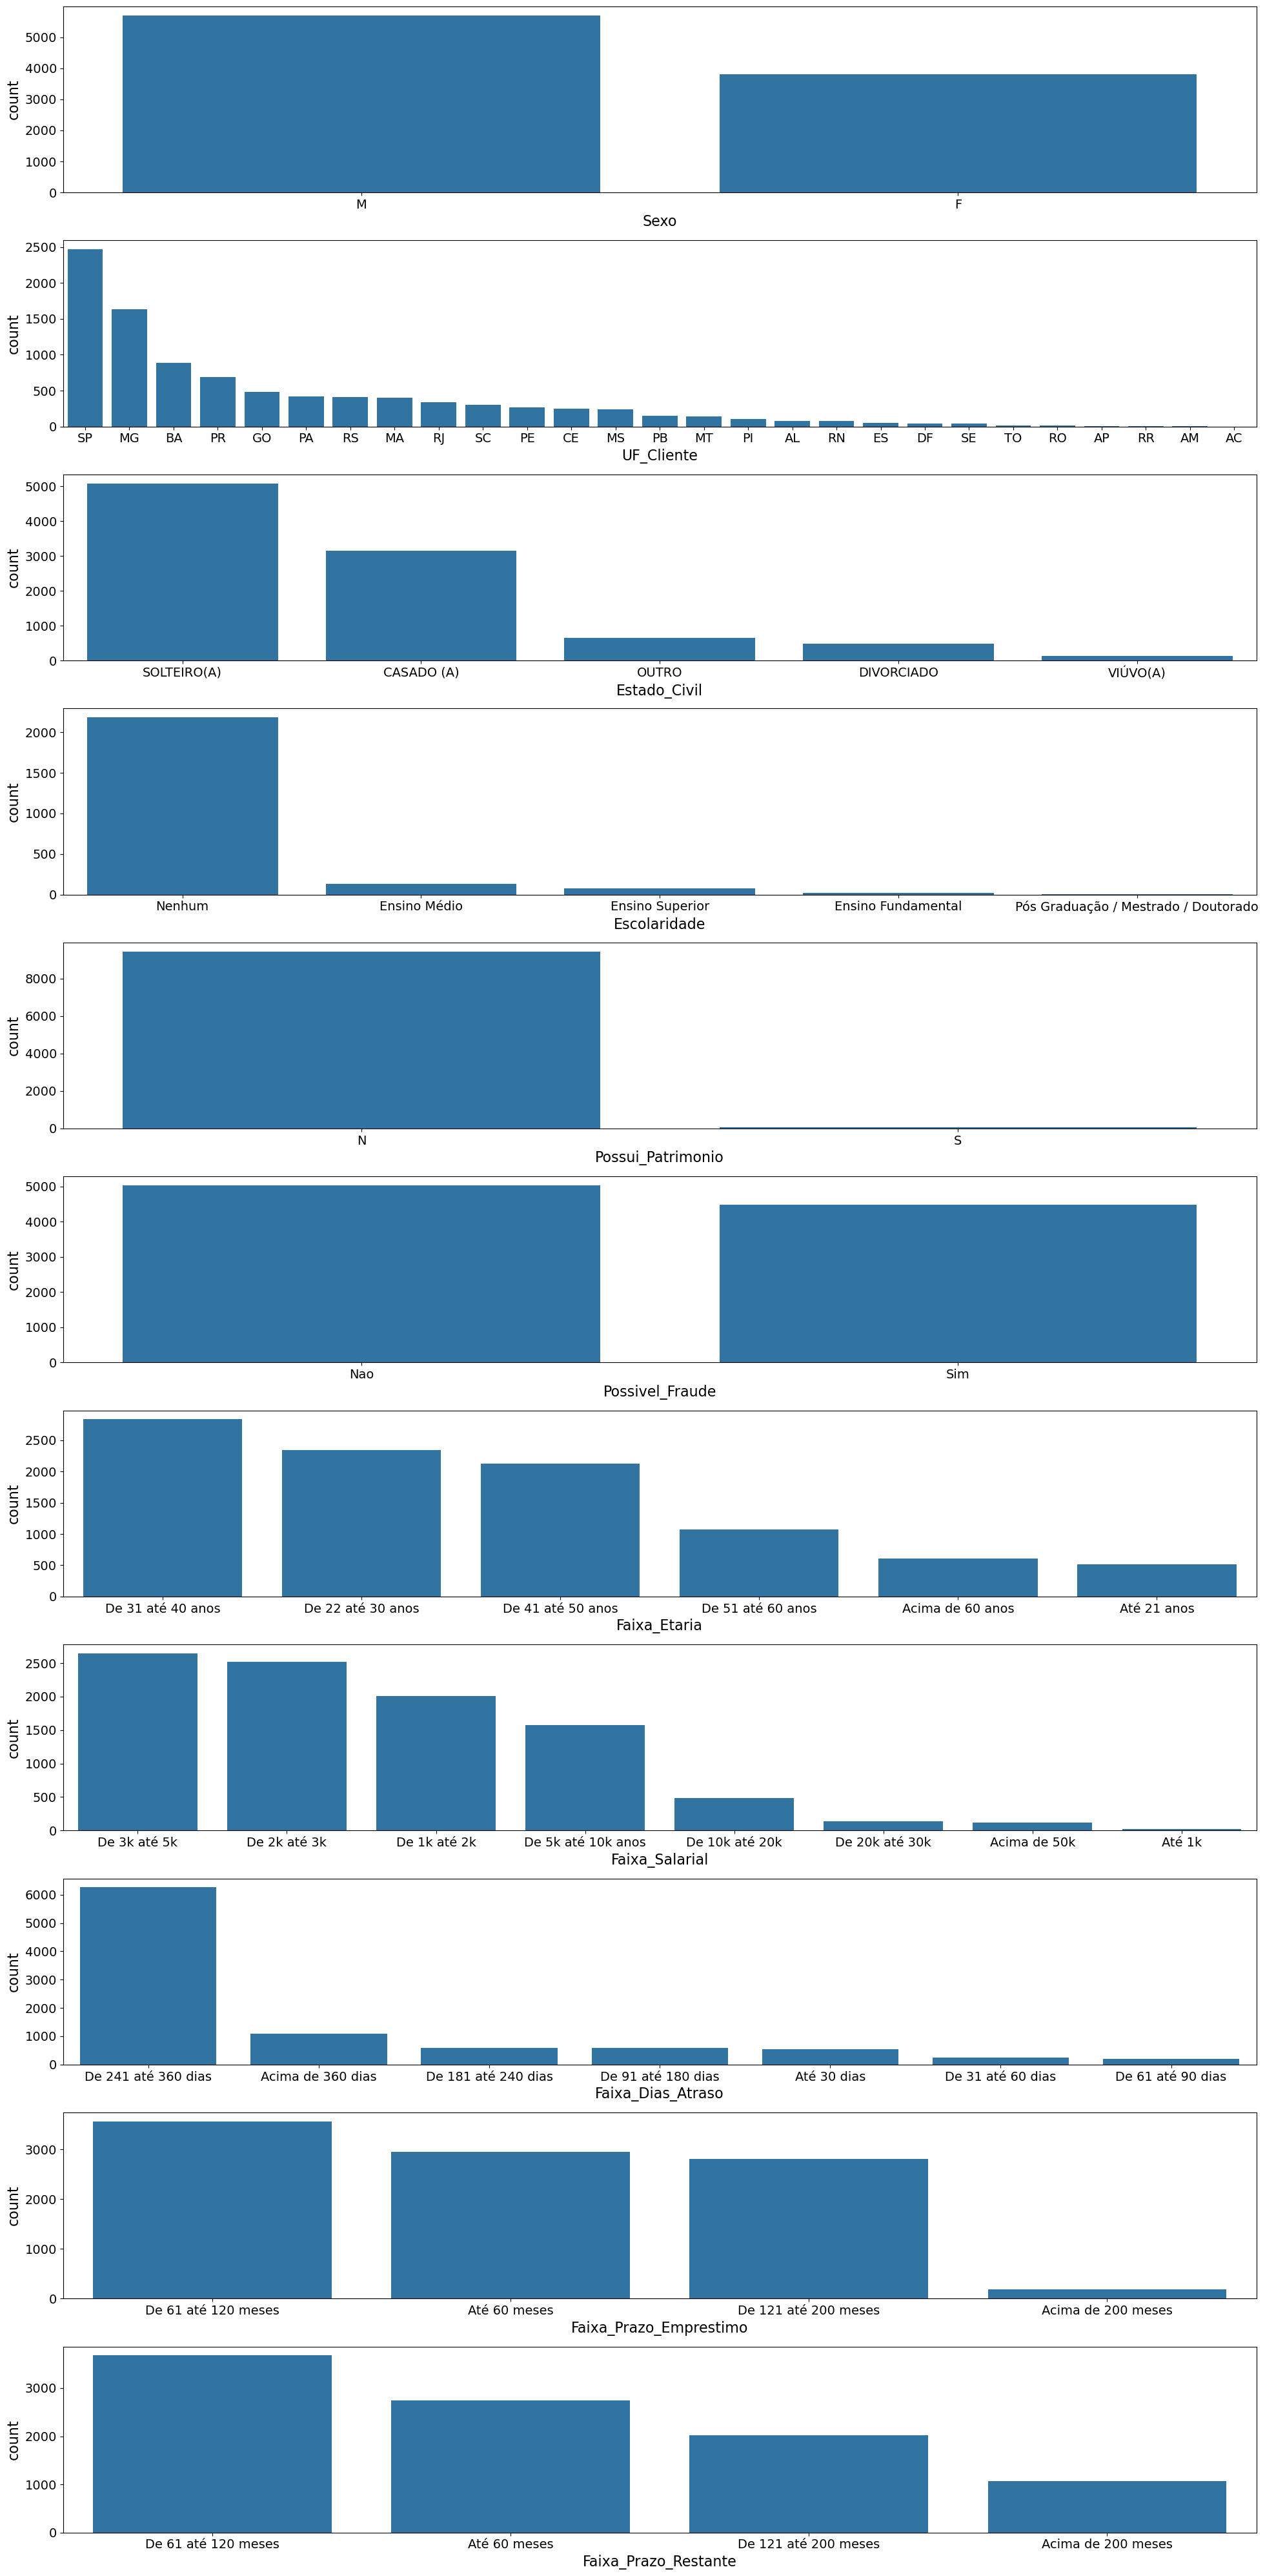

In [70]:
plt.rcParams['figure.figsize'] = [20.00, 40.00]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(11, 1)

linha = 0
for i in categoricas:
    ordem = df[i].value_counts().sort_values(ascending=False).index
    sns.countplot(data=df, x=i, order=ordem, ax=axes[linha])
    axes[linha].set_ylabel(axes[linha].get_ylabel(), fontsize=16)
    axes[linha].set_xlabel(axes[linha].get_xlabel(), fontsize=16)
    axes[linha].tick_params(axis='x', labelsize=14)  # Aumentando os rótulos do eixo X (categorias)
    axes[linha].tick_params(axis='y', labelsize=14)  # Aumentando os rótulos do eixo Y (frequências)
    linha += 1
     
plt.show()

#### Avaliando colunas que usaremos para nossa análise
Após análise, descartaremos as colunas:

* Contrato
* Data_Contratacao
* VL_Patrimonio
* Escolaridade
* Idade (transformado em faixa etária)
* Valor_Renda (transformado em faixa etária)
* Prazo_Emprestimo (transformado em faixa de renda)
* QT_Dias_Atraso (transformado em faixa de atraso)
* Prazo_Restante (transformado em faixa de prazo)

In [71]:
# Criando novo dataframe, apenas com as colunas que vamos utilizar

# Selecionando colunas
columns = ['Sexo', 'UF_Cliente', 'Perc_Juros', 
       'VL_Emprestimo', 'VL_Emprestimo_ComJuros', 'QT_Total_Parcelas_Pagas',
       'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso',
       'Qt_Renegociacao', 'Estado_Civil', 'QT_Parcelas_Atraso', 'Saldo_Devedor', 
       'Total_Pago', 'Faixa_Prazo_Restante', 'Faixa_Salarial', 'Faixa_Prazo_Emprestimo', 'Faixa_Etaria', 
       'Faixa_Dias_Atraso', 'Possivel_Fraude']

df_tratado = pd.DataFrame(df, columns=columns)

In [72]:
# Shape do novo dataframe
df_tratado.shape

(9517, 19)

In [73]:
# Tipo dos dados
df_tratado.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              9517 non-null   object  
 1   UF_Cliente                        9517 non-null   object  
 2   Perc_Juros                        9517 non-null   float64 
 3   VL_Emprestimo                     9517 non-null   float64 
 4   VL_Emprestimo_ComJuros            9517 non-null   float64 
 5   QT_Total_Parcelas_Pagas           9517 non-null   int64   
 6   QT_Total_Parcelas_Pagas_EmDia     9517 non-null   int64   
 7   QT_Total_Parcelas_Pagas_EmAtraso  9517 non-null   int64   
 8   Qt_Renegociacao                   9517 non-null   int64   
 9   Estado_Civil                      9517 non-null   object  
 10  QT_Parcelas_Atraso                9517 non-null   int64   
 11  Saldo_Devedor                     9517 non-null   float6

In [74]:
# Verificando se há valores nulos
df_tratado.isnull().sum()

Sexo                                0
UF_Cliente                          0
Perc_Juros                          0
VL_Emprestimo                       0
VL_Emprestimo_ComJuros              0
QT_Total_Parcelas_Pagas             0
QT_Total_Parcelas_Pagas_EmDia       0
QT_Total_Parcelas_Pagas_EmAtraso    0
Qt_Renegociacao                     0
Estado_Civil                        0
QT_Parcelas_Atraso                  0
Saldo_Devedor                       0
Total_Pago                          0
Faixa_Prazo_Restante                0
Faixa_Salarial                      0
Faixa_Prazo_Emprestimo              0
Faixa_Etaria                        0
Faixa_Dias_Atraso                   0
Possivel_Fraude                     0
dtype: int64

In [75]:
# Verificando dados estatísticos
df_tratado.describe()

,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago
count,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00
mean,19.65,81881.89,94164.17,7.89,4.11,1.60,1.24,5.35,90560.27,8166.21
std,3.82,94138.06,108258.77,5.17,4.04,2.31,1.17,5.32,111050.54,16697.76
min,7.00,3500.00,4025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,18.00,20000.00,23000.00,2.00,1.00,0.00,0.00,0.00,18546.85,1202.04
50%,20.00,50000.00,57500.00,9.00,2.00,1.00,1.00,4.00,45375.30,3949.91
75%,22.00,100000.00,115000.00,13.00,6.00,2.00,2.00,11.00,119721.25,8302.01
max,28.00,500000.00,575000.00,35.00,35.00,14.00,9.00,15.00,625000.00,396385.00


In [76]:
# Verificando valores únicos
valores_unicos = []
for i in df_tratado.columns[0:19].tolist():
    print(i, ':', len(df_tratado[i].astype(str).value_counts()))
    valores_unicos.append(len(df_tratado[i].astype(str).value_counts()))

Sexo : 2
UF_Cliente : 27
Perc_Juros : 21
VL_Emprestimo : 61
VL_Emprestimo_ComJuros : 61
QT_Total_Parcelas_Pagas : 24
QT_Total_Parcelas_Pagas_EmDia : 24
QT_Total_Parcelas_Pagas_EmAtraso : 15
Qt_Renegociacao : 10
Estado_Civil : 5
QT_Parcelas_Atraso : 16
Saldo_Devedor : 7654
Total_Pago : 7022
Faixa_Prazo_Restante : 4
Faixa_Salarial : 8
Faixa_Prazo_Emprestimo : 4
Faixa_Etaria : 6
Faixa_Dias_Atraso : 7
Possivel_Fraude : 2


#### Análise Exploratória das variáveis categóricas
O objetivo dessa análise é
* Entender como essas variáveis estão relacionadas à variável target
* Avaliar as variáveis e descartar aquelas que não têm aplicação para nosso modelo

In [77]:
# Inserindo as variáveis categóricas numa lista
categoricas = []
for i in df_tratado.columns[0:19].tolist():
    if df_tratado.dtypes[i] == 'object' or df_tratado.dtypes[i] == 'category':
        categoricas.append(i)

categoricas

['Sexo',
 'UF_Cliente',
 'Estado_Civil',
 'Faixa_Prazo_Restante',
 'Faixa_Salarial',
 'Faixa_Prazo_Emprestimo',
 'Faixa_Etaria',
 'Faixa_Dias_Atraso',
 'Possivel_Fraude']

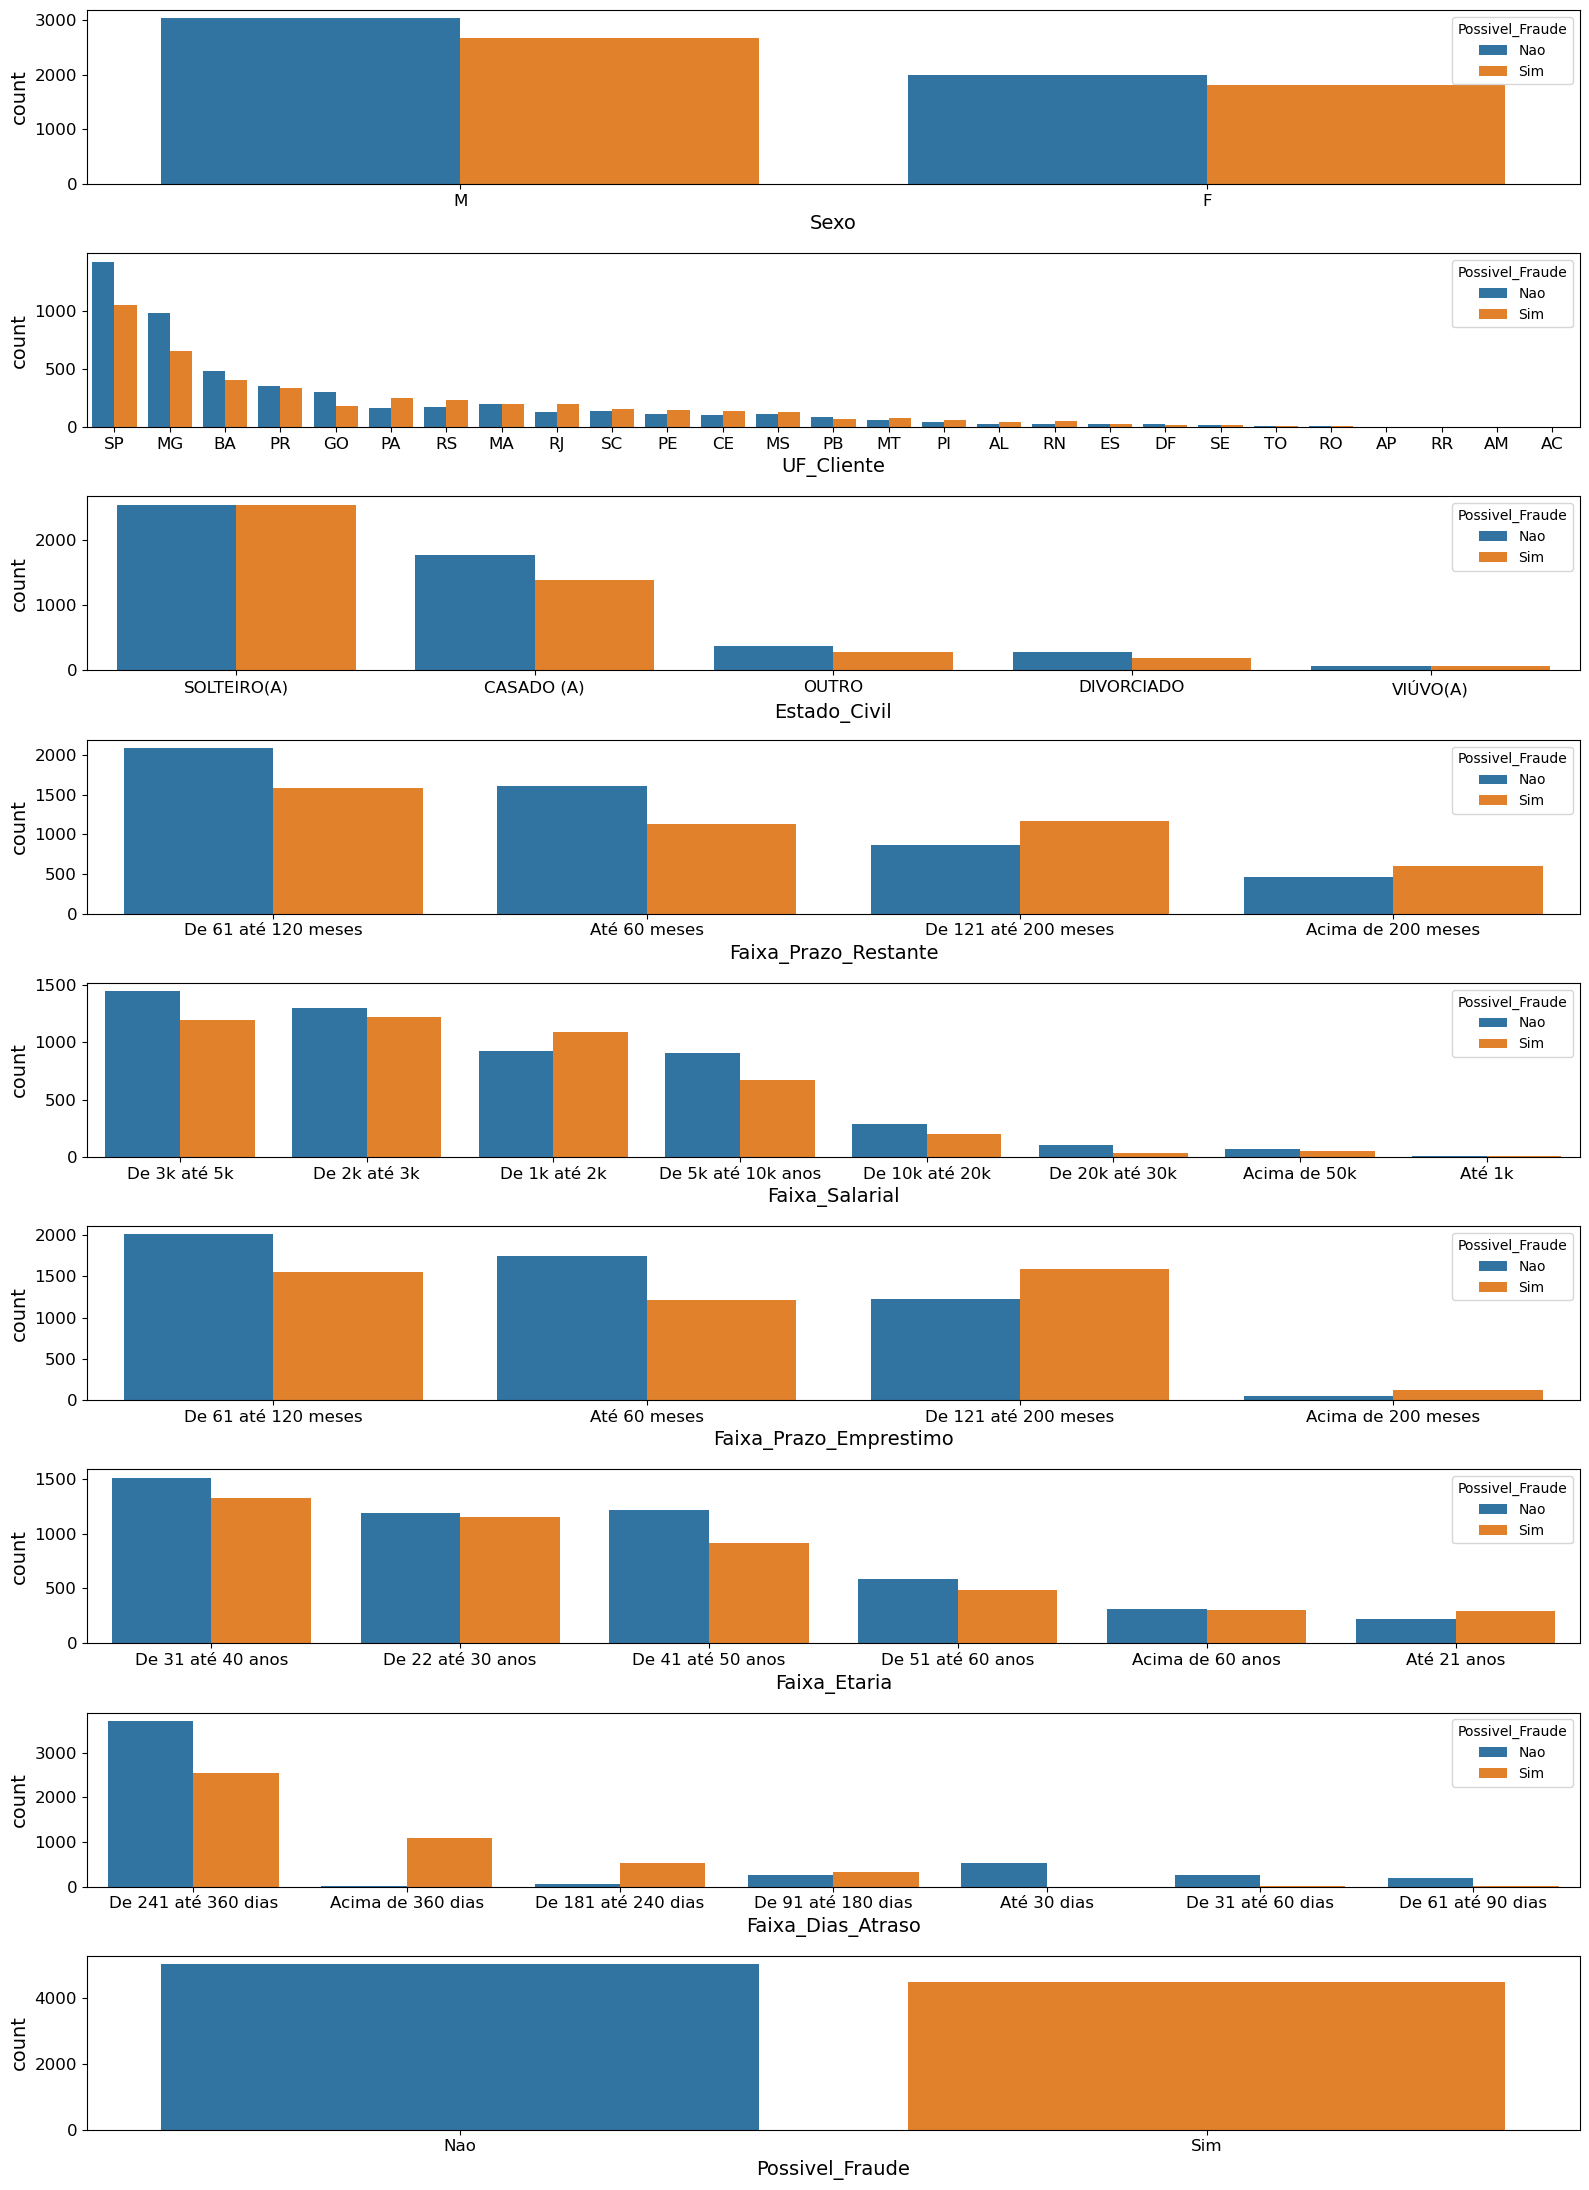

In [83]:
plt.rcParams['figure.figsize'] = [16.00, 22.00]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(9, 1)

linha = 0
for i in categoricas:
    ordem = df_tratado[i].value_counts().sort_values(ascending=False).index
    sns.countplot(data=df_tratado, x=i, order=ordem, hue='Possivel_Fraude', ax=axes[linha])
    axes[linha].set_ylabel(axes[linha].get_ylabel(), fontsize=14)
    axes[linha].set_xlabel(axes[linha].get_xlabel(), fontsize=14)
    axes[linha].tick_params(axis='x', labelsize=12)
    axes[linha].tick_params(axis='y', labelsize=12)  
    linha += 1
     
plt.show()

#### Análise Exploratória das variáveis numéricas
O objetivo dessa análise é
* Entender melhor as variáveis numéricas
* Fazer uma análise estatística das variáveis (média, moda, mediana, desvio padrão, correlações, outliers, distribuição dos dados)

In [84]:
# Inserindo as variáveis numéricas numa lista
numericas = []
for i in df_tratado.columns[0:19].tolist():
    if df_tratado.dtypes[i] == 'int64' or df_tratado.dtypes[i] == 'float64':
        numericas.append(i)

numericas

['Perc_Juros',
 'VL_Emprestimo',
 'VL_Emprestimo_ComJuros',
 'QT_Total_Parcelas_Pagas',
 'QT_Total_Parcelas_Pagas_EmDia',
 'QT_Total_Parcelas_Pagas_EmAtraso',
 'Qt_Renegociacao',
 'QT_Parcelas_Atraso',
 'Saldo_Devedor',
 'Total_Pago']

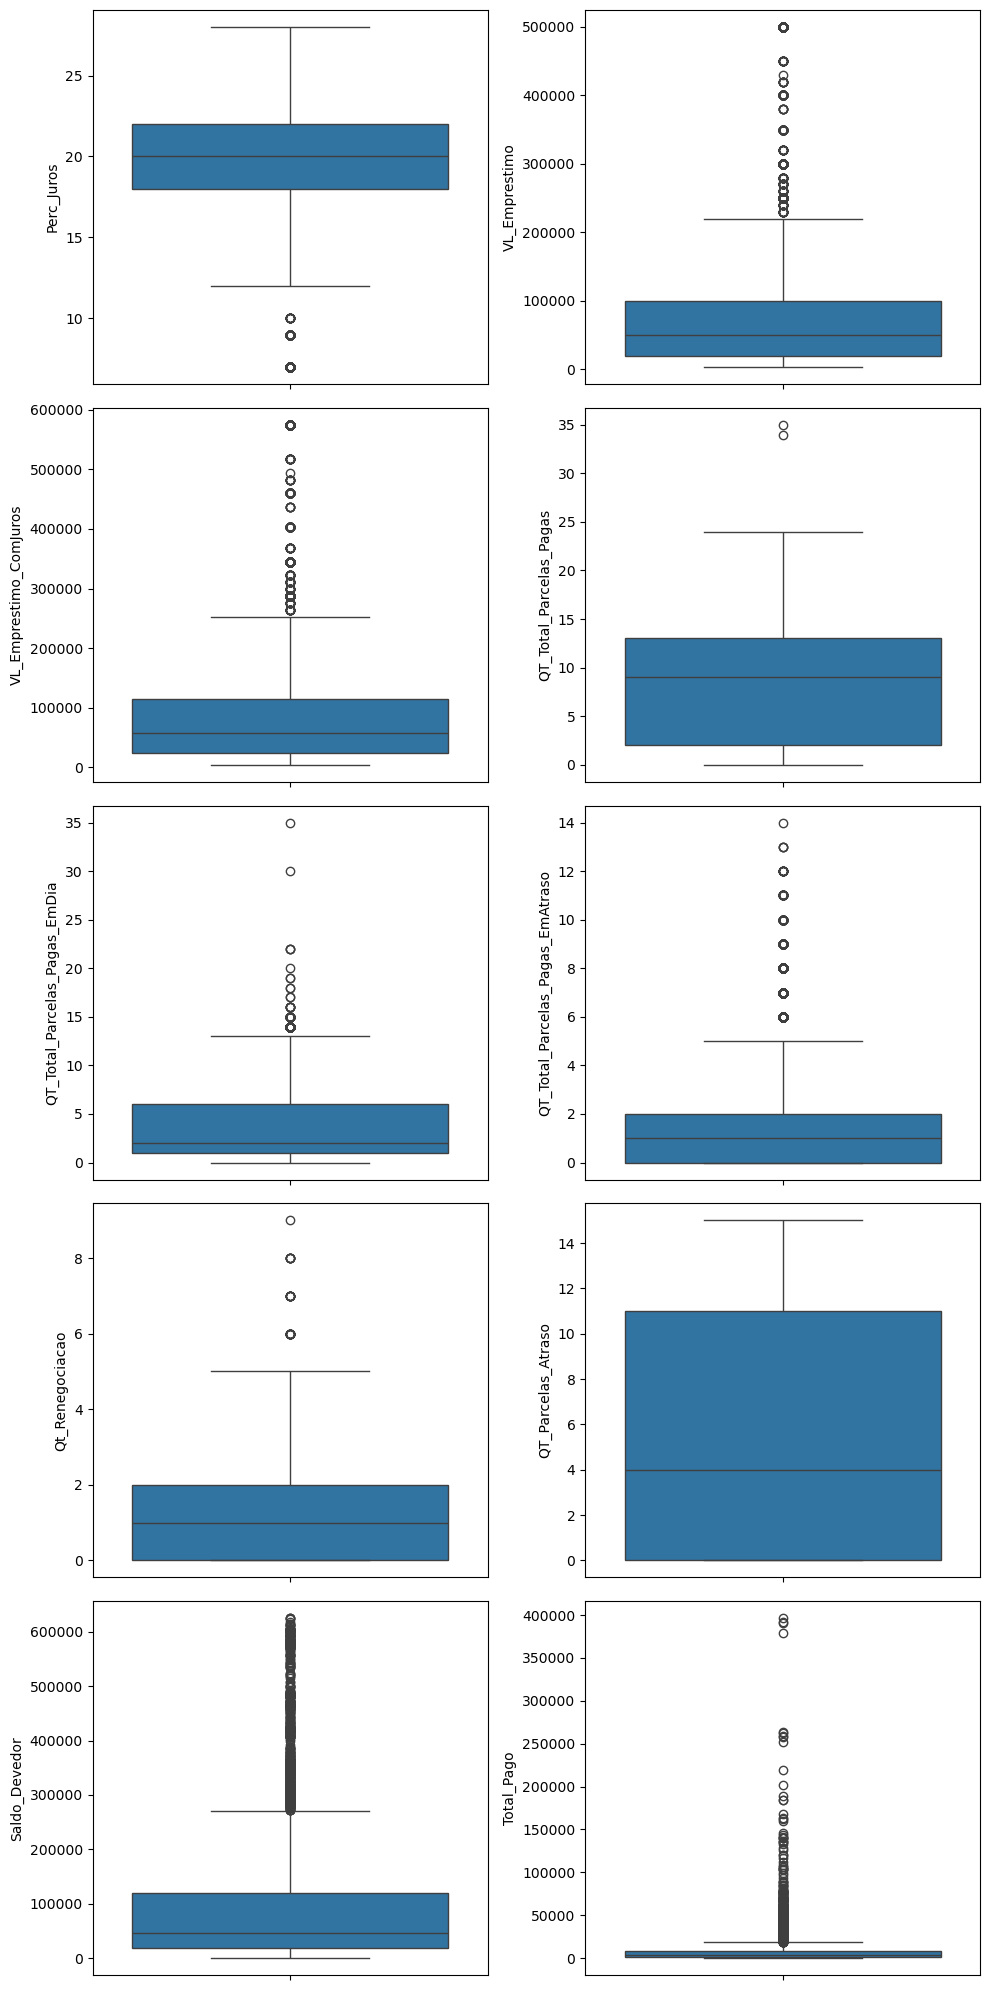

In [85]:
# Criando boxplots com as variáveis numéricas para identificar possíveis outliers
plt.rcParams['figure.figsize'] = [10.00, 20.00]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(5, 2)

linha = 0
coluna = 0
for i in numericas:
    sns.boxplot(data = df_tratado, y=i, ax=axes[linha][coluna])
    coluna +=1
    if coluna == 2:
        linha += 1
        coluna = 0
plt.show()

In [86]:
# Carregando variáveis categóricas para OneHotEncoding, exceto a variável target
categoricas = []
for i in df_tratado.columns[0:18].tolist():
    if df_tratado.dtypes[i] == 'object' or df_tratado.dtypes[i] == 'category':
        categoricas.append(i)

In [87]:
# Criando o encoder e aplicando o OneHotEncoder
lb = LabelEncoder()

for var in categoricas:
    df_tratado[var] = lb.fit_transform(df_tratado[var])

In [88]:
# Verificando existência de nulos após transformação
df_tratado.isnull().sum()

Sexo                                0
UF_Cliente                          0
Perc_Juros                          0
VL_Emprestimo                       0
VL_Emprestimo_ComJuros              0
QT_Total_Parcelas_Pagas             0
QT_Total_Parcelas_Pagas_EmDia       0
QT_Total_Parcelas_Pagas_EmAtraso    0
Qt_Renegociacao                     0
Estado_Civil                        0
QT_Parcelas_Atraso                  0
Saldo_Devedor                       0
Total_Pago                          0
Faixa_Prazo_Restante                0
Faixa_Salarial                      0
Faixa_Prazo_Emprestimo              0
Faixa_Etaria                        0
Faixa_Dias_Atraso                   0
Possivel_Fraude                     0
dtype: int64

In [89]:
# Verificando dados
df_tratado.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Prazo_Restante,Faixa_Salarial,Faixa_Prazo_Emprestimo,Faixa_Etaria,Faixa_Dias_Atraso,Possivel_Fraude
0,1,25,23.00,80000.00,92000.00,15,9,1,0,1,0,91759.97,7717.08,2,7,2,4,3,Nao
1,1,10,20.00,50000.00,57500.00,10,10,0,0,3,4,53981.18,6756.59,3,3,3,2,6,Nao
2,1,4,18.00,100000.00,115000.00,15,5,1,0,0,0,101150.02,17929.06,3,6,3,3,3,Nao
3,1,10,20.00,30000.00,34500.00,1,1,0,0,3,13,36208.10,369.10,3,3,3,1,0,Sim
4,1,10,20.00,60000.00,69000.00,16,16,0,0,0,0,60984.00,11845.24,3,5,3,5,3,Nao


In [90]:
# Visualizando tipo das variáveis
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sexo                              9517 non-null   int32  
 1   UF_Cliente                        9517 non-null   int32  
 2   Perc_Juros                        9517 non-null   float64
 3   VL_Emprestimo                     9517 non-null   float64
 4   VL_Emprestimo_ComJuros            9517 non-null   float64
 5   QT_Total_Parcelas_Pagas           9517 non-null   int64  
 6   QT_Total_Parcelas_Pagas_EmDia     9517 non-null   int64  
 7   QT_Total_Parcelas_Pagas_EmAtraso  9517 non-null   int64  
 8   Qt_Renegociacao                   9517 non-null   int64  
 9   Estado_Civil                      9517 non-null   int32  
 10  QT_Parcelas_Atraso                9517 non-null   int64  
 11  Saldo_Devedor                     9517 non-null   float64
 12  Total_

In [91]:
# Visualizando qtd de dados na variável target
var_target = df_tratado.Possivel_Fraude.value_counts()
var_target

Possivel_Fraude
Nao    5035
Sim    4482
Name: count, dtype: int64

In [92]:
# Separando as variáveis em preditoras e target
PREDITORAS = df_tratado.iloc[:, 0:18]
TARGET = df_tratado.iloc[:, 18]

In [93]:
# Visualizando preditoras
PREDITORAS.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Prazo_Restante,Faixa_Salarial,Faixa_Prazo_Emprestimo,Faixa_Etaria,Faixa_Dias_Atraso
0,1,25,23.00,80000.00,92000.00,15,9,1,0,1,0,91759.97,7717.08,2,7,2,4,3
1,1,10,20.00,50000.00,57500.00,10,10,0,0,3,4,53981.18,6756.59,3,3,3,2,6
2,1,4,18.00,100000.00,115000.00,15,5,1,0,0,0,101150.02,17929.06,3,6,3,3,3
3,1,10,20.00,30000.00,34500.00,1,1,0,0,3,13,36208.10,369.10,3,3,3,1,0
4,1,10,20.00,60000.00,69000.00,16,16,0,0,0,0,60984.00,11845.24,3,5,3,5,3


In [94]:
# Visualizando target
TARGET.head()

0    Nao
1    Nao
2    Nao
3    Sim
4    Nao
Name: Possivel_Fraude, dtype: object

In [95]:
# Para reproduzir o mesmo resultado
seed = 100

# Balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplicando o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

<Axes: title={'center': 'Possíveis Fraudes X Não Fraudes'}, xlabel='Possivel_Fraude'>

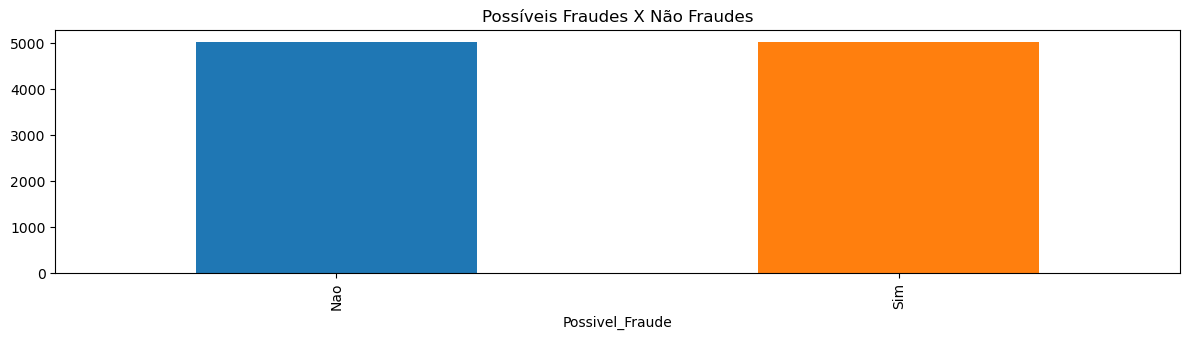

In [96]:
# Visualizando a varivável target balanceada
plt.rcParams['figure.figsize'] = [12.00, 3.50]
plt.rcParams['figure.autolayout'] = True
TARGET_RES.value_counts().plot(kind='bar', title='Possíveis Fraudes X Não Fraudes', color=['#1F77B4', '#FF7F0E'])

In [97]:
# Total registros antes do balanceamento - Preditoras
PREDITORAS.shape

(9517, 18)

In [98]:
# Total registros depois do balanceamento - Target
TARGET.shape

(9517,)

In [99]:
# Total registros antes do balanceamento - Preditoras
PREDITORAS_RES.shape

(10070, 18)

In [100]:
# Total registros depois do balanceamento - Target
TARGET_RES.shape

(10070,)

##### Dividindo os Dados em Treino e Teste

In [101]:
# Divisão entre treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size=0.3, random_state=42)

In [102]:
# Verificando treino
X_treino.shape

(7049, 18)

##### Normalizando as Variáveis

In [103]:
# Normalização das variáveis
normalizador = MinMaxScaler()
X_treino_normalizado = normalizador.fit_transform(X_treino)
X_teste_normalizado = normalizador.transform(X_teste)

In [104]:
# Visualizando dados normalizados
X_treino_normalizado

array([[0.        , 0.65384615, 0.57142857, ..., 0.66666667, 1.        ,
        0.5       ],
       [0.        , 0.96153846, 0.61904762, ..., 0.66666667, 1.        ,
        0.33333333],
       [0.        , 0.15384615, 1.        , ..., 0.33333333, 0.4       ,
        0.        ],
       ...,
       [1.        , 0.96153846, 0.71428571, ..., 0.66666667, 0.4       ,
        0.5       ],
       [1.        , 0.88461538, 0.57142857, ..., 0.66666667, 0.8       ,
        1.        ],
       [1.        , 0.96153846, 0.85714286, ..., 1.        , 0.8       ,
        0.5       ]])

##### Padronização das Variáveis

In [105]:
# Padronizando
padronizador = StandardScaler()
X_treino_padronizado = padronizador.fit_transform(X_treino)
X_teste_padronizado = padronizador.transform(X_teste)

In [106]:
# Visualizando dados padronizados
X_treino_padronizado

array([[-1.19681542,  0.23366629, -0.17570736, ..., -0.0233426 ,
         1.62609594,  0.21145893],
       [-1.19681542,  1.30019073,  0.08623913, ..., -0.0233426 ,
         1.62609594, -0.50688999],
       [-1.19681542, -1.49943592,  2.18181105, ..., -1.17398585,
        -0.6960982 , -1.94358782],
       ...,
       [ 0.83555073,  1.30019073,  0.61013211, ..., -0.0233426 ,
        -0.6960982 ,  0.21145893],
       [ 0.83555073,  1.03355962, -0.17570736, ..., -0.0233426 ,
         0.85203123,  2.36650569],
       [ 0.83555073,  1.30019073,  1.39597158, ...,  1.12730065,
         0.85203123,  0.21145893]])

### Encontrando o Melhor Modelo de Machine Learning
Vamos criar, treinar e avaliar diferentes modelos de machine learning, sendo eles:
* Random Forest
* SVM
* KNN

#### Random Forest

In [131]:
# Construtor do modelo
randomForest = RandomForestClassifier()

In [132]:
# Parâmetros default
randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [133]:
# Valores para o grid de hiperparâmetros
n_estimators = np.array([100,200,300])
max_depth = np.array([10,20])
criterion = np.array(["gini", "entropy"])
max_features = np.array(["sqrt", "log2", None])
min_samples_split = np.array([2,5])
min_samples_leaf = np.array([1,2,3])


# Grid de hiperparâmetros
grid_parametros = dict(n_estimators = n_estimators,
                       max_depth = max_depth,
                       criterion = criterion,
                       max_features = max_features,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf)

# Criando o modelo com o Grid de Hiperparametros
randomForest = GridSearchCV(RandomForestClassifier(), grid_parametros, cv=3, n_jobs=3)

# Treinando os modelos
inicio = time.time()
randomForest.fit(X_treino_normalizado, Y_treino)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {randomForest.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {randomForest.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Número de Treinamentos Realizados: ", treinos_rf.shape[0])

Acurácia em Treinamento: 99.23%

Hiperparâmetros Ideais: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Tempo de Treinamento do Modelo:  1672.49

Número de Treinamentos Realizados:  216


In [134]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_jobs=3)

# Construção do modelo
clf = clf.fit(X_treino_normalizado, Y_treino)

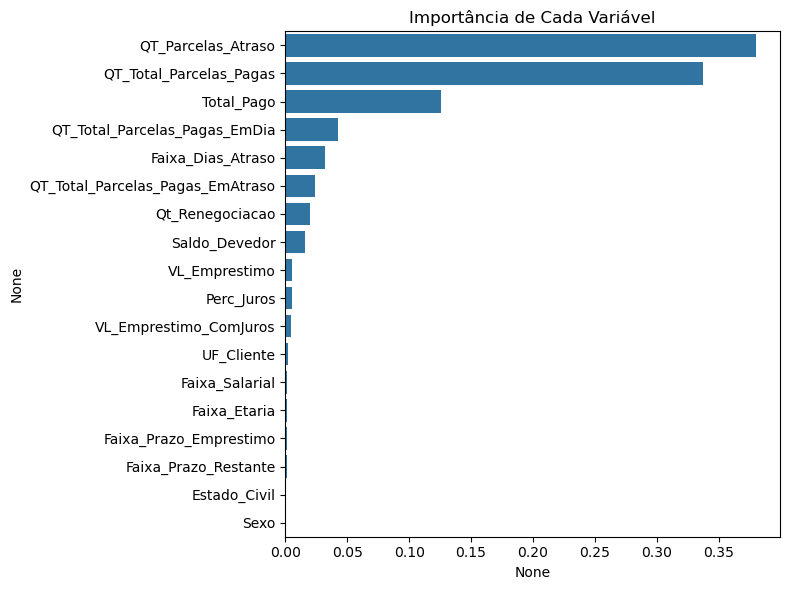

In [135]:
# Exibindo a importância das variáveis no modelo preditivo
plt.rcParams['figure.figsize'] = [8.00, 6.00]
plt.rcParams['figure.autolayout'] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending=False)

sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de Cada Variável')
plt.show()

In [136]:
# Visualizando o percentual de importância de cada variável
# As variáveis com percentual 0 podem ser posteriormente removidas, pois não têm importância em nosso modelo
importances.sort_values(ascending=False)

QT_Parcelas_Atraso                 0.38
QT_Total_Parcelas_Pagas            0.34
Total_Pago                         0.13
QT_Total_Parcelas_Pagas_EmDia      0.04
Faixa_Dias_Atraso                  0.03
QT_Total_Parcelas_Pagas_EmAtraso   0.02
Qt_Renegociacao                    0.02
Saldo_Devedor                      0.02
VL_Emprestimo                      0.01
Perc_Juros                         0.01
VL_Emprestimo_ComJuros             0.00
UF_Cliente                         0.00
Faixa_Salarial                     0.00
Faixa_Etaria                       0.00
Faixa_Prazo_Emprestimo             0.00
Faixa_Prazo_Restante               0.00
Estado_Civil                       0.00
Sexo                               0.00
dtype: float64

In [137]:
# Criando dicionário de métricas e metadados
modelo_rf = {'Melhores Hiperparâmetros':randomForest.best_params_,
            'Número de Modelos Treinados':treinos_rf.shape[0],
            'Melhor Score':str(round(randomForest.best_score_ * 100,2))+'%'}

In [138]:
modelo_rf

{'Melhores Hiperparâmetros': {'criterion': 'gini',
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 100},
 'Número de Modelos Treinados': 216,
 'Melhor Score': '99.23%'}

In [139]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_jobs=3)

# Construção do modelo
clf = clf.fit(X_treino_normalizado, Y_treino)

In [152]:
# Score variável treino
scores = clf.score(X_treino_normalizado, Y_treino)
scores

0.9977301744928359

In [153]:
# Score variável teste
scores = clf.score(X_teste_normalizado, Y_teste)
scores

0.9910625620655412

#### SVM

In [140]:
# Construtor do modelo
modelo_svm = SVC()

In [141]:
# Parâmetros default
modelo_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [142]:
# Valores para o grid de hiperparâmetros
grid_parametros = {'C':[0.1, 1, 10, 100],
                  'gamma':[1, 0.1, 0.01, 0.001],
                  #'kernel':['poly', 'rbf', 'sigmoid', 'linear'],
                  'degree':[2, 3, 4],
                  'coef0':[0.5, 1],
                  #'decision_function_shape':['ovo', 'ovr'],
                  'max_iter':[-1,1]}

svm = GridSearchCV(modelo_svm, grid_parametros, n_jobs=3)

# Treinando os modelos
inicio = time.time()
svm.fit(X_treino_normalizado, Y_treino)
fim = time.time()

# Obtendo e visualizando os parâmetros treinoados
treinos_svm = pd.DataFrame(svm.cv_results_)


# Acurácia em Treino
print(f"Acurácia em Treinamento: {svm.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {svm.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Número de Treinamentos Realizados: ", treinos_svm.shape[0])

Acurácia em Treinamento: 98.92%

Hiperparâmetros Ideais: {'C': 100, 'coef0': 0.5, 'degree': 2, 'gamma': 0.01, 'max_iter': -1}

Tempo de Treinamento do Modelo:  709.39

Número de Treinamentos Realizados:  192


In [143]:
# Dicionário de métricas e metadados
modelo_svm = {'Melhores Hiperparâmetros':svm.best_params_,
               'Número de Modelos Treinados': treinos_svm.shape[0],  
               'Melhor Score': str(round(svm.best_score_ * 100,2))+"%"}

In [144]:
modelo_svm

{'Melhores Hiperparâmetros': {'C': 100,
  'coef0': 0.5,
  'degree': 2,
  'gamma': 0.01,
  'max_iter': -1},
 'Número de Modelos Treinados': 192,
 'Melhor Score': '98.92%'}

#### KNN

In [145]:
# Classificador
knn = KNeighborsClassifier()

In [146]:
# Parametros default
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [147]:
# Valores para o grid de hiperparametros
n_neighbors = np.array([3, 4, 5, 6, 7])
algorithm = np.array(['auto', 'ball_tree', 'kd_tree', 'brute'])
leaf_size = np.array([30, 31, 32])
metric =  np.array(['minkowski', 'euclidean'])


# Grid de hiperparâmetros
grid_parametros = dict(n_neighbors = n_neighbors,
                       algorithm = algorithm,
                       leaf_size = leaf_size,
                       metric = metric)

knn = GridSearchCV(knn, grid_parametros, n_jobs=3)

# Treinando os modelos
inicio = time.time()
knn.fit(X_treino_normalizado, Y_treino)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_knn = pd.DataFrame(knn.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {knn.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {knn.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Número de Treinamentos Realizados: ", treinos_knn.shape[0])

Acurácia em Treinamento: 97.04%

Hiperparâmetros Ideais: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 5}

Tempo de Treinamento do Modelo:  340.16

Número de Treinamentos Realizados:  120


In [148]:
# Dicionário de métricas e metadados
modelo_knn = {'Melhores Hiperparâmetros':knn.best_params_,
               'Número de Modelos Treinados': treinos_knn.shape[0],  
               'Melhor Score': str(round(knn.best_score_ * 100,2))+"%"}

In [149]:
modelo_knn

{'Melhores Hiperparâmetros': {'algorithm': 'auto',
  'leaf_size': 30,
  'metric': 'minkowski',
  'n_neighbors': 5},
 'Número de Modelos Treinados': 120,
 'Melhor Score': '97.04%'}

In [150]:
# Gerando o DataFrame com todos os valores de todos os modelos treinados
resumo = pd.DataFrame({'Random Forest':pd.Series(modelo_rf),
                       'SVM':pd.Series(modelo_svm),                       
                       'KNN':pd.Series(modelo_knn)
                      })

In [151]:
resumo

,Random Forest,SVM,KNN
Melhores Hiperparâmetros,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...","{'C': 100, 'coef0': 0.5, 'degree': 2, 'gamma':...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
Número de Modelos Treinados,216,192,120
Melhor Score,99.23%,98.92%,97.04%
